In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from sklearn.model_selection import train_test_split
import os, shutil
from pathlib import Path
from collections import defaultdict

src_dir = Path("/kaggle/input/major-final-kymograms-cropped/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with their class labels
all_images = []
class_map = defaultdict(list)

for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    images = list(cls_dir.glob("*.png"))
    for img in images:
        all_images.append((img, cls))  # Store path and class label
        class_map[cls].append(img)

# Step 2: Global split - 15% test
trainval, test = train_test_split(all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images])

# Step 3: Split remaining into 70% train, 30% val
train, val = train_test_split(trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval])

# Step 4: Copy images to appropriate folders
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)

In [2]:
import random
import shutil
from pathlib import Path

train_dir = Path("/kaggle/working/tertiary_split/train")

# Step 1: Count images in each class
class_counts = {}
for cls_folder in train_dir.iterdir():
    if cls_folder.is_dir():
        class_counts[cls_folder.name] = len(list(cls_folder.glob("*.png")))

# Step 2: Find maximum class count
max_count = max(class_counts.values())

# Step 3: Oversample each class to match max_count
for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)  # Randomly pick with replacement

        for i, img in enumerate(to_duplicate):
            # Create new filename to avoid overwriting
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print(" Training set balanced by oversampling.")

 Training set balanced by oversampling.


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Define base path
base_path = Path("/kaggle/working/tertiary_split")

# Transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet-152
resnet = models.resnet152(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classifier
resnet.eval()

# Function to extract features
def extract_features(data_path, save_prefix):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc=f"Extracting from {save_prefix}"):
            output = resnet(inputs)
            features.append(output)
            labels.append(targets)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    np.save(f"/kaggle/working/{save_prefix}_features.npy", features)
    np.save(f"/kaggle/working/{save_prefix}_labels.npy", labels)

# Extract for train, val, and test
extract_features(base_path / "train", "train")
extract_features(base_path / "val", "val")
extract_features(base_path / "test", "test")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 197MB/s]  
Extracting from test: 100%|██████████| 47/47 [04:18<00:00,  5.51s/it]


In [4]:
import torch.nn as nn

class ConvNeXtV2Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Load the saved features and labels
train_features = np.load("/kaggle/working/train_features.npy")
train_labels = np.load("/kaggle/working/train_labels.npy")
val_features = np.load("/kaggle/working/val_features.npy")
val_labels = np.load("/kaggle/working/val_labels.npy")

# Convert to torch tensors
train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), 
                              torch.tensor(train_labels, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_features, dtype=torch.float32), 
                            torch.tensor(val_labels, dtype=torch.long))

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
import torch
import torch.nn as nn
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = ConvNeXtV2Classifier(input_dim=2048, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training settings
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_convnextv2.pth")

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {int(elapsed)}s - "
          f"Train Acc: {train_acc:.4f} - Train Loss: {train_loss:.4f} - "
          f"Val Acc: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

# Load best weights
model.load_state_dict(torch.load("best_model_convnextv2.pth"))


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - 1s - Train Acc: 0.6948 - Train Loss: 0.6672 - Val Acc: 0.8455 - Val Loss: 0.4024
Epoch 2/30 - 1s - Train Acc: 0.9135 - Train Loss: 0.2337 - Val Acc: 0.9319 - Val Loss: 0.1844
Epoch 3/30 - 1s - Train Acc: 0.9677 - Train Loss: 0.0953 - Val Acc: 0.9311 - Val Loss: 0.1741
Epoch 4/30 - 1s - Train Acc: 0.9830 - Train Loss: 0.0538 - Val Acc: 0.9731 - Val Loss: 0.0727
Epoch 5/30 - 1s - Train Acc: 0.9907 - Train Loss: 0.0321 - Val Acc: 0.9873 - Val Loss: 0.0428
Epoch 6/30 - 1s - Train Acc: 0.9938 - Train Loss: 0.0193 - Val Acc: 0.9834 - Val Loss: 0.0559
Epoch 7/30 - 1s - Train Acc: 0.9927 - Train Loss: 0.0204 - Val Acc: 0.9667 - Val Loss: 0.1013
Epoch 8/30 - 1s - Train Acc: 0.9946 - Train Loss: 0.0167 - Val Acc: 0.9897 - Val Loss: 0.0454
Epoch 9/30 - 1s - Train Acc: 0.9955 - Train Loss: 0.0136 - Val Acc: 0.9786 - Val Loss: 0.0626
Epoch 10/30 - 1s - Train Acc: 0.9981 - Train Loss: 0.0065 - Val Acc: 0.9929 - Val Loss: 0.0325
Epoch 11/30 - 1s - Train Acc: 0.9997 - Train Loss: 0.0020 -

/tmp/ipykernel_31/1275480140.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_convnextv2.pth"))


<All keys matched successfully>

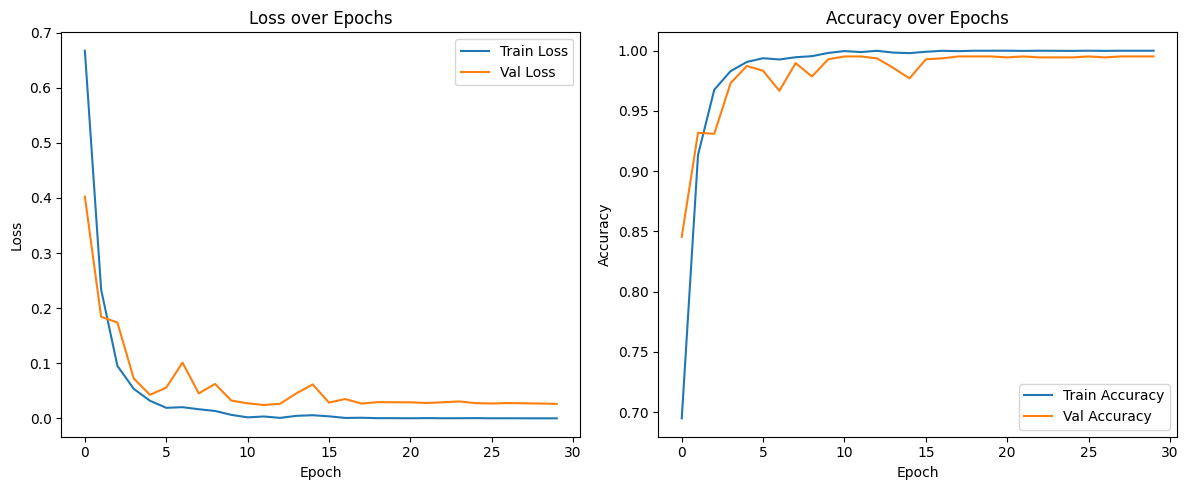

In [7]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
class_names = datasets.ImageFolder(root=base_path / "train").classes
n_classes = len(class_names)



Validation Performance of Tertiary Classifier
Metrics             Value
----------------------------------------
functional
F1 Score (%)           99.63
Precision (%)          99.26
Recall (%)            100.00
Sensitivity (%)       100.00
Specificity (%)        99.80
----------------------------------------
healthy
F1 Score (%)           99.68
Precision (%)         100.00
Recall (%)             99.37
Sensitivity (%)        99.37
Specificity (%)       100.00
----------------------------------------
organic
F1 Score (%)           98.77
Precision (%)          98.04
Recall (%)             99.50
Sensitivity (%)        99.50
Specificity (%)        99.62
----------------------------------------
Overall Accuracy (%)   99.52


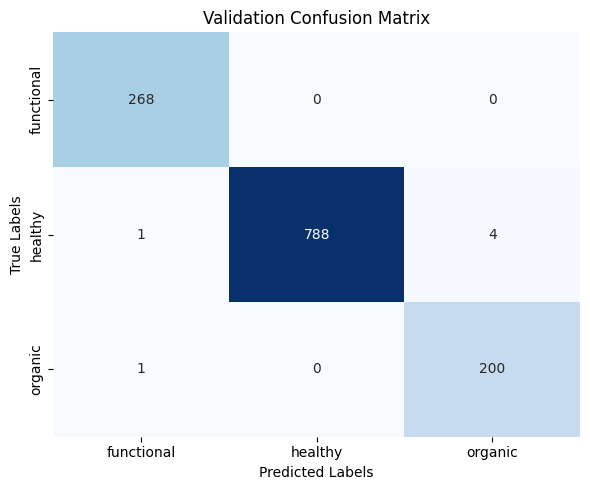

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()

val_y_true = []
val_y_pred = []
val_y_probs = []

with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        outputs = model(val_x)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        val_y_true.extend(val_y.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred)
val_y_probs = np.array(val_y_probs)

# AUC Score (macro-averaged)
val_auc = roc_auc_score(val_y_true, val_y_probs, multi_class='ovr', average='macro') * 100

# Classification report
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

# Sensitivity and Specificity
val_sensitivity = []
val_specificity = []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

# Accuracy
val_acc = accuracy_score(val_y_true, val_y_pred) * 100

# Print Validation Report
print("\nValidation Performance of Tertiary Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{val_acc:>8.2f}")

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [14]:
# Load test features and labels
test_features = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# Convert to TensorDataset and DataLoader
test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                             torch.tensor(test_labels, dtype=torch.long))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Test Performance of Tertiary Classifier
Metrics             Value
----------------------------------------
functional
AUC (%)                99.97
F1 Score (%)           98.89
Precision (%)          99.05
Recall (%)             98.73
Sensitivity (%)        98.73
Specificity (%)        99.74
----------------------------------------
healthy
AUC (%)                99.96
F1 Score (%)           99.57
Precision (%)          99.68
Recall (%)             99.46
Sensitivity (%)        99.46
Specificity (%)        99.46
----------------------------------------
organic
AUC (%)               100.00
F1 Score (%)           99.37
Precision (%)          98.74
Recall (%)            100.00
Sensitivity (%)       100.00
Specificity (%)        99.76
----------------------------------------
Overall Accuracy (%)   99.39
Macro Avg AUC (%)      99.97


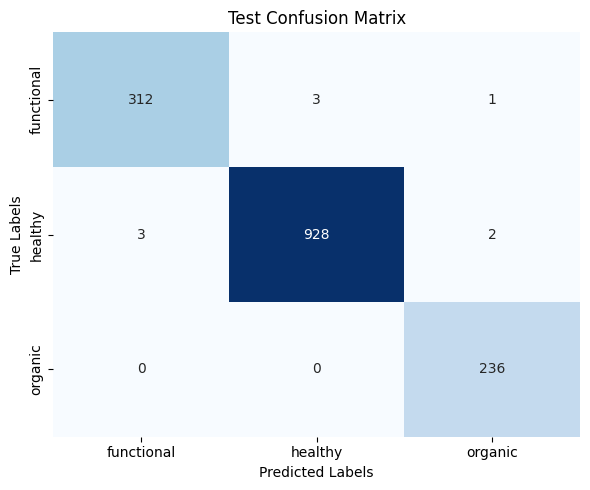

In [15]:
from sklearn.preprocessing import label_binarize

model.eval()

test_y_true = []
test_y_pred = []
test_y_probs = []

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        outputs = model(test_x)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        test_y_true.extend(test_y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)
test_y_probs = np.array(test_y_probs)

# Binarize the true labels for AUC calculation
test_y_true_bin = label_binarize(test_y_true, classes=list(range(n_classes)))

# Class-wise AUC scores
test_auc_per_class = roc_auc_score(test_y_true_bin, test_y_probs, average=None) * 100

# Macro average AUC
test_auc_macro = roc_auc_score(test_y_true_bin, test_y_probs, average='macro') * 100

# Classification report
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

# Sensitivity and Specificity
test_sensitivity = []
test_specificity = []

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

# Accuracy
test_acc = accuracy_score(test_y_true, test_y_pred) * 100

# Print Test Report
print("\nTest Performance of Tertiary Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<20}{test_auc_per_class[i]:>8.2f}")
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{test_acc:>8.2f}")
print(f"{'Macro Avg AUC (%)':<20}{test_auc_macro:>8.2f}")

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Test Accuracy after epoch 30: 99.39%


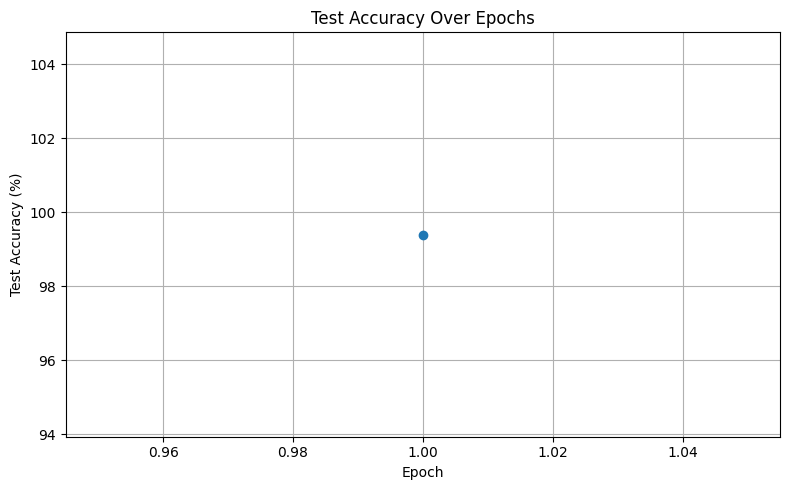

In [17]:
test_accuracies = []
# === Evaluation on test set ===
model.eval()
test_y_true = []
test_y_pred = []

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        outputs = model(test_x)
        preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        test_y_true.extend(test_y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())

# Compute test accuracy
test_acc = accuracy_score(test_y_true, test_y_pred) * 100
test_accuracies.append(test_acc)
print(f"Test Accuracy after epoch {epoch+1}: {test_acc:.2f}%")
# Plot test accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


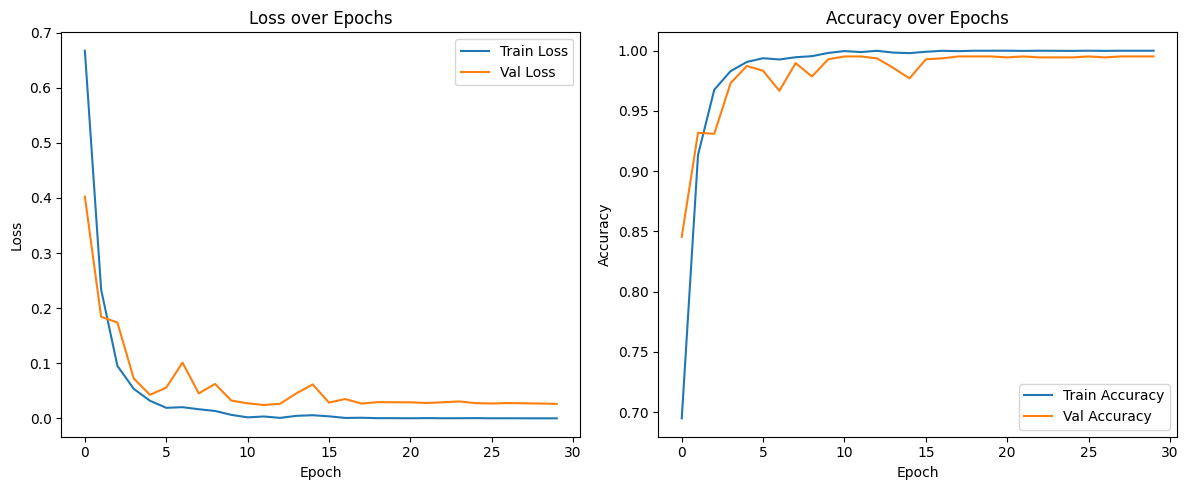

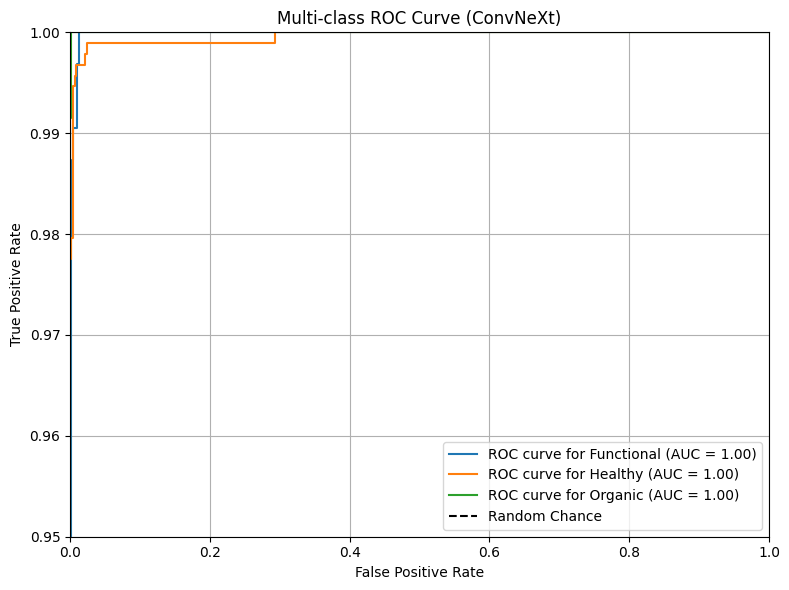

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. Save Training History to CSV
# ----------------------------
# Make sure `history` is defined before this
history_df = pd.DataFrame(history)
history_df.to_csv("accuracy_loss_perconvnext_tertiary_epoch.csv", index=False)

# ----------------------------
# 2. Plot Accuracy & Loss
# ----------------------------
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.get('train_loss', []), label='Train Loss')
plt.plot(history.get('val_loss', []), label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.get('train_acc', []), label='Train Accuracy')
plt.plot(history.get('val_acc', []), label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ----------------------------
# 3. Compute ROC & AUC
# ----------------------------
n_classes = 3
y_true = test_y_true
y_pred_probs = test_y_probs

# Ensure y_true and y_pred_probs are defined
if 'y_true' not in locals() or 'y_pred_probs' not in locals():
    raise NameError("Please define `y_true` (true labels) and `y_pred_probs` (predicted probabilities) first.")

# One-hot encode true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
labels = ['Functional', 'Healthy', 'Organic']  # Modify as needed

# Per-class ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ----------------------------
# 4. Plot ROC Curve
# ----------------------------
plt.figure(figsize=(8, 6))

# Per-class curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'ROC curve for {labels[i]} (AUC = {roc_auc[i]:.2f})')

# Micro-average curve


# Plot random guess line
plt.plot([0, 0.95], [0, 0.95], 'k--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.95, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (ConvNeXt)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_convnext_tertiary.png", dpi=300)
plt.show()

# ----------------------------
# 5. Save ROC Values to CSV
# ----------------------------
roc_data = []

# Individual class data
for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({
            "class": labels[i],
            "fpr": fp,
            "tpr": tp,
            "auc": roc_auc[i]
        })

# Micro-average data
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({
        "class": "micro",
        "fpr": fp,
        "tpr": tp,
        "auc": roc_auc["micro"]
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_values_convnext_tertiary.csv", index=False)


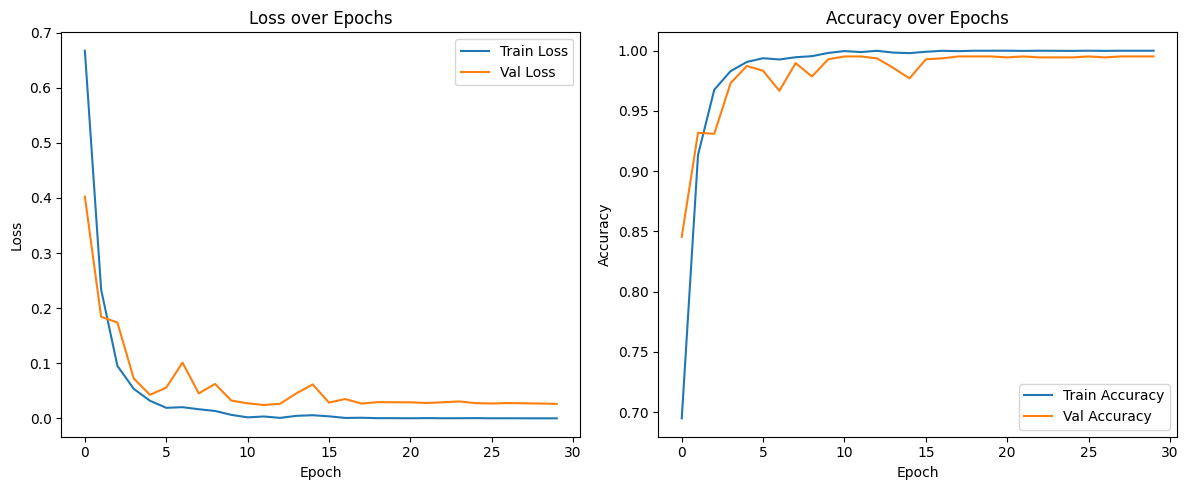

NameError: Please define `y_true` (list of true labels) and `y_pred_probs` (model's predicted probabilities) before running this section.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. Save Training History to CSV
# ----------------------------

# Ensure 'history' is defined as a dictionary with lists
# Example: history = {'train_loss': [...], 'val_loss': [...], 'train_acc': [...], 'val_acc': [...]}
history_df = pd.DataFrame(history)
history_df.to_csv("accuracy_loss_perconvnext_tertiary_epoch.csv", index=False)

# ----------------------------
# 2. Plot Accuracy & Loss
# ----------------------------
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.get('train_loss', []), label='Train Loss')
plt.plot(history.get('val_loss', []), label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.get('train_acc', []), label='Train Accuracy')
plt.plot(history.get('val_acc', []), label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ----------------------------
# 3. Compute ROC & AUC
# ----------------------------

# Ensure y_true and y_pred_probs are defined
# y_true = list/array of ground truth labels (e.g., [0, 1, 2, ...])
# y_pred_probs = np.array of predicted probabilities, shape = (n_samples, 3)

n_classes = 3

# Safety check for input
if 'y_true' not in locals() or 'y_pred_probs' not in locals():
    raise NameError("Please define `y_true` (list of true labels) and `y_pred_probs` (model's predicted probabilities) before running this section.")

# Convert to one-hot encoded format
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
labels = ['class_0', 'class_1', 'class_2']  # Modify if needed

# Per-class ROC & AUC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC & AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ----------------------------
# 4. Save ROC Values to CSV
# ----------------------------

roc_data = []

# Per-class data
for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({
            "class": labels[i],
            "fpr": fp,
            "tpr": tp,
            "auc": roc_auc[i]
        })

# Micro-average data
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({
        "class": "micro",
        "fpr": fp,
        "tpr": tp,
        "auc": roc_auc["micro"]
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_values_convnext_tertiary.csv", index=False)
